In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
from scipy.linalg import expm

import math
from utils.plotTools import plot_qwak
import os
import ast
import numpy as np
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

import numpy as np
import networkx as nx
from scipy.linalg import expm
import time
from scripts import load_list_from_file, write_list_to_file, load_or_generate_data, draw_graph, draw_graph_from_adjacency_matrix,print_matrix

In [2]:
def coins(phi,gamma):
    ry = np.array([[np.cos(phi/2), -np.sin(np.cos(phi/2))],[np.sin(phi/2),np.cos(phi/2)]])
    p = np.array([[np.exp(-1j*((gamma)/2)),0],[0,np.exp(1j*((gamma)/2))]])
    return ry @ p

def coins2(theta,phi1,phi2):
    c = np.array([[np.cos(theta), np.exp(1j*phi1)*np.sin(theta)],[np.exp(1j*phi2)*np.sin(theta),-np.exp(1j*(phi1+phi2))*np.cos(theta)]])
    return np.round(c,2)

def u3_matrix(theta, phi, lambda_):
    """
    Creates the U3 matrix as defined in the image uploaded by the user.
    
    Args:
    - theta: float, angle in radians
    - phi: float, angle in radians
    - lambda_: float, angle in radians
    
    Returns:
    - U3: 2x2 numpy array representing the unitary matrix
    """
    return np.round(np.array([
        [np.cos(theta / 2), -np.exp(1j * lambda_) * np.sin(theta / 2)],
        [np.exp(1j * phi) * np.sin(theta / 2), np.exp(1j * (phi + lambda_)) * np.cos(theta / 2)]
    ]),5)


In [3]:
def coin_init_state(init):
    if init == "0":
        psi0 = np.array([[1],[0]])
    if init == "1":
        psi0 = np.array([[0],[1]])
    if init == "01":
        psi0 = np.array([[1/np.sqrt(2)],[(-1*1j)/np.sqrt(2)]])
    return psi0

def walker_state(N,nodeList,coinState):
    stateVec = np.zeros((N,1))
    nodeAmp = np.sqrt(len(nodeList))
    for node in nodeList:
        stateVec[node] = 1/nodeAmp
    g = np.kron(coinState,stateVec)
    return g

In [4]:
def walk_op(N):
    state0 = np.array([1,0])
    state1 = np.array([0,1])
    c00= np.outer(state0,state0)
    c11= np.outer(state1,state1)
    ShiftPlus = np.roll(np.eye(N),1,axis=0)
    ShiftMinus = np.roll(np.eye(N),-1,axis=0)
    Shift = np.kron(c00,ShiftPlus) + np.kron(c11,ShiftMinus) 
    return Shift

In [5]:
def CU_op(coin, shift,N):
    U = shift.dot(np.kron(coin,np.eye(N)))
    return U

In [6]:
def final_state(U,psi0,steps):
    for t in range(0,steps):
        psi0=U.dot(psi0)
    return psi0

In [7]:
def prob_vec(psiN,N):
    probs = np.zeros((N,1))
    for x in range(N):
        probs[x]=psiN[x]*np.conjugate(psiN[x]) + psiN[N+x]*np.conjugate(psiN[N+x]) #duvida aqui
    return probs

C:\Users\jaime\AppData\Local\Temp\ipykernel_20628\494796815.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[x]=psiN[x]*np.conjugate(psiN[x]) + psiN[N+x]*np.conjugate(psiN[N+x]) #duvida aqui


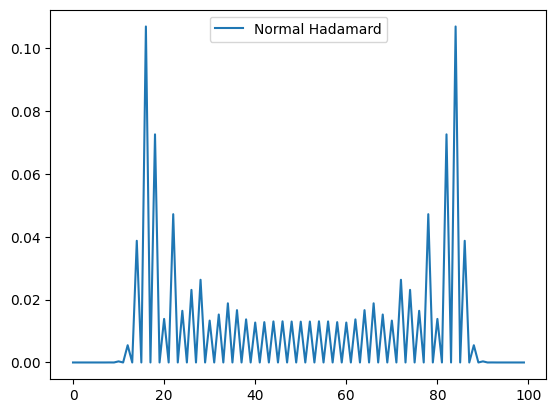

In [10]:
def cqwalk(N,nodeList,Steps,init,coin):
    coin = coin
    shift= walk_op(N)
    U = CU_op(coin,shift,N)
    coinstate = coin_init_state(init)
    psi0 = walker_state(N,nodeList,coinstate)
    psiN = final_state(U,psi0,Steps)
    probvec = prob_vec(psiN,N)
    return probvec

N = 100
steps = 50


init = '01'

coin = u3_matrix(np.pi/2,0,np.pi)

nodeList = [50]

qw = cqwalk(N,nodeList,steps,init,coin)


plt.plot(qw,label=f"Normal Hadamard")

plt.legend()
plt.show()

In [12]:
import numpy as np

def hadamard_coin():
    return (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]])

def shift_operator(N):
    shift_left = np.roll(np.eye(N), -1, axis=0)
    shift_right = np.roll(np.eye(N), 1, axis=0)
    return np.kron(np.array([[1, 0], [0, 0]]), shift_right) + np.kron(np.array([[0, 0], [0, 1]]), shift_left)

def initial_state(N, position):
    psi_coin = (1/np.sqrt(2)) * np.array([1, 1j]) # Initial coin state
    psi_position = np.zeros(N)
    psi_position[position] = 1 # Initial position
    return np.kron(psi_coin, psi_position)

def evolve(rho, U):
    return U @ rho @ U.conj().T

def measure(rho, N):
    # Calculate probabilities for each position
    probabilities = np.array([np.real(np.trace(rho[i*2:(i+1)*2, i*2:(i+1)*2])) for i in range(N)])
    if np.sum(probabilities) == 0:
        probabilities = np.ones(N) / N  # Assign equal probability if sum is 0 (should not normally happen)
    else:
        probabilities /= np.sum(probabilities)  # Normalize probabilities

    measured_position = np.random.choice(np.arange(N), p=probabilities)
    # Construct the measurement projector
    projector = np.zeros((N*2, N*2))
    projector[measured_position*2, measured_position*2] = 1
    projector[measured_position*2+1, measured_position*2+1] = 1
    rho_after = projector @ rho @ projector.T
    rho_after /= np.trace(rho_after)  # Normalize the state
    
    return rho_after, measured_position

def run_quantum_walk(N, steps, initial_position):
    U = shift_operator(N) @ np.kron(hadamard_coin(), np.eye(N))
    psi0 = initial_state(N, initial_position)
    rho = np.outer(psi0, psi0.conj())
    measurement_outcomes = []

    for _ in range(steps):
        rho, measured_position = measure(evolve(rho, U), N)
        measurement_outcomes.append(measured_position)

    return measurement_outcomes

# Example parameters
N = 10  # Number of positions
steps = 5  # Number of steps in the walk
initial_position = 5  # Initial position of the walker

measurement_outcomes = run_quantum_walk(N, steps, initial_position)
print("Measurement outcomes at each step:", measurement_outcomes)


Measurement outcomes at each step: [3, 3, 4, 4, 9]


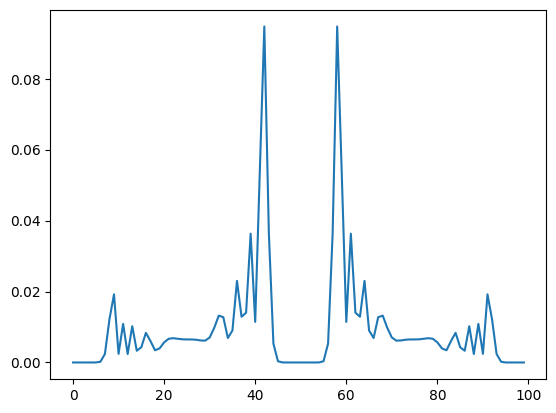

In [16]:
import numpy as np

def hadamard_coin():
    return (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]])

def shift_operator(N):
    shift_left = np.roll(np.eye(N), -1, axis=0)
    shift_right = np.roll(np.eye(N), 1, axis=0)
    return np.kron(np.array([[1, 0], [0, 0]]), shift_right) + np.kron(np.array([[0, 0], [0, 1]]), shift_left)

def initial_state(N, position):
    psi_coin = (1/np.sqrt(2)) * np.array([1, 1j])  # Initial coin state
    psi_position = np.zeros(N)
    psi_position[position] = 1  # Initial position
    return np.kron(psi_coin, psi_position)

def evolve(rho, U):
    return U @ rho @ U.conj().T

def final_probability_distribution(rho, N):
    probabilities = np.array([np.real(np.trace(rho[i*2:(i+1)*2, i*2:(i+1)*2])) for i in range(N)])
    return probabilities

def run_quantum_walk_for_distribution(N, steps, initial_position):
    U = shift_operator(N) @ np.kron(hadamard_coin(), np.eye(N))
    psi0 = initial_state(N, initial_position)
    rho = np.outer(psi0, psi0.conj())

    for _ in range(steps):
        rho = evolve(rho, U)

    probabilities = final_probability_distribution(rho, N)
    return probabilities

# Example parameters
N = 100  # Number of positions
steps = 50  # Number of steps in the walk
initial_position = 50  # Initial position of the walker

probabilities = run_quantum_walk_for_distribution(N, steps, initial_position)
# print("Probability distribution after", steps, "steps:", probabilities)

plt.plot(probabilities)


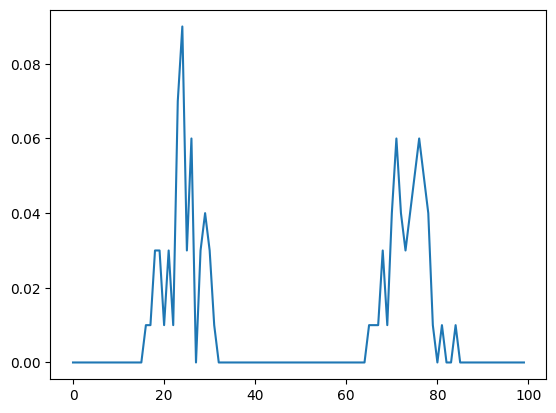

In [27]:
import numpy as np

def hadamard_coin():
    return (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]])

def shift_operator(N):
    shift_left = np.roll(np.eye(N), -1, axis=0)
    shift_right = np.roll(np.eye(N), 1, axis=0)
    return np.kron(np.array([[1, 0], [0, 0]]), shift_right) + np.kron(np.array([[0, 0], [0, 1]]), shift_left)

def initial_state(N, position):
    psi_coin = np.array([[1],[0]])
    psi_position = np.zeros(N)
    psi_position[position] = 1 # Initial position
    return np.kron(psi_coin, psi_position)

def evolve(rho, U):
    return U @ rho @ U.conj().T

def measure(rho, N):
    probabilities = np.array([np.real(np.trace(rho[i*2:(i+1)*2, i*2:(i+1)*2])) for i in range(N)])
    if np.sum(probabilities) == 0:
        probabilities = np.ones(N) / N
    else:
        probabilities /= np.sum(probabilities)
    measured_position = np.random.choice(np.arange(N), p=probabilities)
    projector = np.zeros((N*2, N*2))
    projector[measured_position*2, measured_position*2] = 1
    projector[measured_position*2+1, measured_position*2+1] = 1
    rho_after = projector @ rho @ projector.T
    rho_after /= np.trace(rho_after)
    return rho_after, measured_position

def run_quantum_walk_with_measurements(N, steps, initial_position, iterations):
    # Store the final positions of each iteration
    final_positions = np.zeros(N)
    for _ in range(iterations):
        U = shift_operator(N) @ np.kron(hadamard_coin(), np.eye(N))
        psi0 = initial_state(N, initial_position)
        rho = np.outer(psi0, psi0.conj())
        for _ in range(steps):
            rho, measured_position = measure(evolve(rho, U), N)
        final_positions[measured_position] += 1
    # Normalize the final positions to get probabilities
    probability_distribution = final_positions / iterations
    return probability_distribution

# Example parameters
N = 100  # Number of positions
steps = 55  # Number of steps in the walk
initial_position = 50  # Initial position of the walker
iterations = 100  # Number of iterations to approximate the probability distribution

probability_distribution = run_quantum_walk_with_measurements(N, steps, initial_position, iterations)
# print("Approximated probability distribution after", steps, "steps with measurements:", probability_distribution)

plt.plot(probability_distribution)